In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-07 23:56:37.467309: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-07 23:56:37.467342: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.1)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:9984, :], y[:9984]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

optimal_schedules = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 10*28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 10*59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 10*1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 10*1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 10*1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 10*2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 10*1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 10*4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in optimal_schedules:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/394


2022-05-07 23:56:40.639781: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-07 23:56:40.639816: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-07 23:56:40.639840: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-07 23:56:40.640056: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


39/39 [==============================] - 2s 19ms/step - loss: 0.7147 - accuracy: 0.4923 - auc: 0.4898 - val_loss: 0.7008 - val_accuracy: 0.5217 - val_auc: 0.5046
Epoch 2/394
39/39 [==============================] - 0s 8ms/step - loss: 0.7122 - accuracy: 0.4964 - auc: 0.4945 - val_loss: 0.6981 - val_accuracy: 0.5284 - val_auc: 0.5106
Epoch 3/394
39/39 [==============================] - 0s 12ms/step - loss: 0.7075 - accuracy: 0.5019 - auc: 0.5026 - val_loss: 0.6960 - val_accuracy: 0.5324 - val_auc: 0.5173
Epoch 4/394
39/39 [==============================] - 0s 8ms/step - loss: 0.7039 - accuracy: 0.5087 - auc: 0.5080 - val_loss: 0.6942 - val_accuracy: 0.5369 - val_auc: 0.5238
Epoch 5/394
39/39 [==============================] - 0s 7ms/step - loss: 0.7045 - accuracy: 0.5057 - auc: 0.5051 - val_loss: 0.6928 - val_accuracy: 0.5389 - val_auc: 0.5306
Epoch 6/394
39/39 [==============================] - 0s 9ms/step - loss: 0.7015 - accuracy: 0.5114 - auc: 0.5164 - val_loss: 0.6914 - val_accurac

39/39 [==============================] - 0s 12ms/step - loss: 0.6513 - accuracy: 0.6220 - auc: 0.6720 - val_loss: 0.6292 - val_accuracy: 0.7168 - val_auc: 0.8019
Epoch 49/394
39/39 [==============================] - 1s 18ms/step - loss: 0.6497 - accuracy: 0.6208 - auc: 0.6736 - val_loss: 0.6269 - val_accuracy: 0.7193 - val_auc: 0.8052
Epoch 50/394
39/39 [==============================] - 0s 11ms/step - loss: 0.6479 - accuracy: 0.6204 - auc: 0.6787 - val_loss: 0.6246 - val_accuracy: 0.7219 - val_auc: 0.8085
Epoch 51/394
39/39 [==============================] - 0s 12ms/step - loss: 0.6477 - accuracy: 0.6204 - auc: 0.6734 - val_loss: 0.6222 - val_accuracy: 0.7250 - val_auc: 0.8116
Epoch 52/394
39/39 [==============================] - 0s 10ms/step - loss: 0.6435 - accuracy: 0.6304 - auc: 0.6873 - val_loss: 0.6198 - val_accuracy: 0.7273 - val_auc: 0.8150
Epoch 53/394
39/39 [==============================] - 0s 10ms/step - loss: 0.6426 - accuracy: 0.6323 - auc: 0.6871 - val_loss: 0.6173 - va

39/39 [==============================] - 0s 7ms/step - loss: 0.5526 - accuracy: 0.7204 - auc: 0.7995 - val_loss: 0.4899 - val_accuracy: 0.8260 - val_auc: 0.9044
Epoch 96/394
39/39 [==============================] - 0s 13ms/step - loss: 0.5505 - accuracy: 0.7247 - auc: 0.8017 - val_loss: 0.4868 - val_accuracy: 0.8271 - val_auc: 0.9056
Epoch 97/394
39/39 [==============================] - 0s 13ms/step - loss: 0.5511 - accuracy: 0.7208 - auc: 0.8002 - val_loss: 0.4839 - val_accuracy: 0.8288 - val_auc: 0.9067
Epoch 98/394
39/39 [==============================] - 0s 9ms/step - loss: 0.5445 - accuracy: 0.7301 - auc: 0.8078 - val_loss: 0.4810 - val_accuracy: 0.8304 - val_auc: 0.9079
Epoch 99/394
39/39 [==============================] - 0s 6ms/step - loss: 0.5402 - accuracy: 0.7315 - auc: 0.8106 - val_loss: 0.4780 - val_accuracy: 0.8321 - val_auc: 0.9089
Epoch 100/394
39/39 [==============================] - 1s 16ms/step - loss: 0.5408 - accuracy: 0.7332 - auc: 0.8108 - val_loss: 0.4751 - val_

Epoch 142/394
39/39 [==============================] - 0s 12ms/step - loss: 0.4701 - accuracy: 0.7809 - auc: 0.8659 - val_loss: 0.3881 - val_accuracy: 0.8734 - val_auc: 0.9349
Epoch 143/394
39/39 [==============================] - 0s 10ms/step - loss: 0.4747 - accuracy: 0.7805 - auc: 0.8611 - val_loss: 0.3868 - val_accuracy: 0.8742 - val_auc: 0.9352
Epoch 144/394
39/39 [==============================] - 0s 10ms/step - loss: 0.4713 - accuracy: 0.7821 - auc: 0.8640 - val_loss: 0.3854 - val_accuracy: 0.8748 - val_auc: 0.9355
Epoch 145/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4624 - accuracy: 0.7887 - auc: 0.8707 - val_loss: 0.3839 - val_accuracy: 0.8755 - val_auc: 0.9358
Epoch 146/394
39/39 [==============================] - 0s 12ms/step - loss: 0.4720 - accuracy: 0.7850 - auc: 0.8643 - val_loss: 0.3827 - val_accuracy: 0.8765 - val_auc: 0.9360
Epoch 147/394
39/39 [==============================] - 0s 9ms/step - loss: 0.4725 - accuracy: 0.7878 - auc: 0.8631 - val_

Epoch 189/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4373 - accuracy: 0.8097 - auc: 0.8848 - val_loss: 0.3451 - val_accuracy: 0.8905 - val_auc: 0.9432
Epoch 190/394
39/39 [==============================] - 0s 12ms/step - loss: 0.4304 - accuracy: 0.8137 - auc: 0.8907 - val_loss: 0.3445 - val_accuracy: 0.8907 - val_auc: 0.9433
Epoch 191/394
39/39 [==============================] - 0s 9ms/step - loss: 0.4281 - accuracy: 0.8153 - auc: 0.8920 - val_loss: 0.3440 - val_accuracy: 0.8909 - val_auc: 0.9434
Epoch 192/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4386 - accuracy: 0.8156 - auc: 0.8866 - val_loss: 0.3435 - val_accuracy: 0.8915 - val_auc: 0.9434
Epoch 193/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4248 - accuracy: 0.8221 - auc: 0.8941 - val_loss: 0.3430 - val_accuracy: 0.8918 - val_auc: 0.9435
Epoch 194/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4373 - accuracy: 0.8096 - auc: 0.8860 - val_los

Epoch 236/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4097 - accuracy: 0.8318 - auc: 0.9032 - val_loss: 0.3263 - val_accuracy: 0.8990 - val_auc: 0.9462
Epoch 237/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4084 - accuracy: 0.8312 - auc: 0.9031 - val_loss: 0.3261 - val_accuracy: 0.8994 - val_auc: 0.9462
Epoch 238/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4121 - accuracy: 0.8273 - auc: 0.9003 - val_loss: 0.3258 - val_accuracy: 0.8996 - val_auc: 0.9462
Epoch 239/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4084 - accuracy: 0.8302 - auc: 0.9033 - val_loss: 0.3255 - val_accuracy: 0.8996 - val_auc: 0.9463
Epoch 240/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3995 - accuracy: 0.8359 - auc: 0.9080 - val_loss: 0.3251 - val_accuracy: 0.8997 - val_auc: 0.9463
Epoch 241/394
39/39 [==============================] - 0s 13ms/step - loss: 0.4098 - accuracy: 0.8322 - auc: 0.9027 - val_los

Epoch 283/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3815 - accuracy: 0.8494 - auc: 0.9163 - val_loss: 0.3147 - val_accuracy: 0.9035 - val_auc: 0.9479
Epoch 284/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3975 - accuracy: 0.8410 - auc: 0.9087 - val_loss: 0.3146 - val_accuracy: 0.9036 - val_auc: 0.9479
Epoch 285/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3875 - accuracy: 0.8440 - auc: 0.9134 - val_loss: 0.3144 - val_accuracy: 0.9037 - val_auc: 0.9479
Epoch 286/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3955 - accuracy: 0.8408 - auc: 0.9108 - val_loss: 0.3143 - val_accuracy: 0.9039 - val_auc: 0.9479
Epoch 287/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3851 - accuracy: 0.8481 - auc: 0.9137 - val_loss: 0.3141 - val_accuracy: 0.9040 - val_auc: 0.9479
Epoch 288/394
39/39 [==============================] - 0s 12ms/step - loss: 0.3872 - accuracy: 0.8465 - auc: 0.9148 - val_los

Epoch 330/394
39/39 [==============================] - 0s 12ms/step - loss: 0.3773 - accuracy: 0.8526 - auc: 0.9183 - val_loss: 0.3068 - val_accuracy: 0.9057 - val_auc: 0.9491
Epoch 331/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3769 - accuracy: 0.8553 - auc: 0.9189 - val_loss: 0.3067 - val_accuracy: 0.9064 - val_auc: 0.9491
Epoch 332/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3729 - accuracy: 0.8569 - auc: 0.9204 - val_loss: 0.3065 - val_accuracy: 0.9068 - val_auc: 0.9491
Epoch 333/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3736 - accuracy: 0.8583 - auc: 0.9208 - val_loss: 0.3063 - val_accuracy: 0.9065 - val_auc: 0.9491
Epoch 334/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3784 - accuracy: 0.8541 - auc: 0.9180 - val_loss: 0.3061 - val_accuracy: 0.9068 - val_auc: 0.9492
Epoch 335/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3729 - accuracy: 0.8596 - auc: 0.9206 - val_los

Epoch 377/394
39/39 [==============================] - 0s 9ms/step - loss: 0.3642 - accuracy: 0.8660 - auc: 0.9251 - val_loss: 0.2994 - val_accuracy: 0.9092 - val_auc: 0.9503
Epoch 378/394
39/39 [==============================] - 0s 13ms/step - loss: 0.3644 - accuracy: 0.8630 - auc: 0.9246 - val_loss: 0.2992 - val_accuracy: 0.9097 - val_auc: 0.9503
Epoch 379/394
39/39 [==============================] - 0s 12ms/step - loss: 0.3692 - accuracy: 0.8607 - auc: 0.9225 - val_loss: 0.2990 - val_accuracy: 0.9094 - val_auc: 0.9504
Epoch 380/394
39/39 [==============================] - 0s 9ms/step - loss: 0.3634 - accuracy: 0.8648 - auc: 0.9243 - val_loss: 0.2989 - val_accuracy: 0.9096 - val_auc: 0.9504
Epoch 381/394
39/39 [==============================] - 1s 13ms/step - loss: 0.3640 - accuracy: 0.8573 - auc: 0.9241 - val_loss: 0.2988 - val_accuracy: 0.9095 - val_auc: 0.9504
Epoch 382/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3554 - accuracy: 0.8662 - auc: 0.9287 - val_l

39/39 [==============================] - 0s 11ms/step - loss: 0.6380 - accuracy: 0.6356 - auc: 0.6958 - val_loss: 0.6094 - val_accuracy: 0.7449 - val_auc: 0.8316
Epoch 29/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6331 - accuracy: 0.6443 - auc: 0.7086 - val_loss: 0.6050 - val_accuracy: 0.7491 - val_auc: 0.8369
Epoch 30/394
39/39 [==============================] - 0s 10ms/step - loss: 0.6302 - accuracy: 0.6480 - auc: 0.7109 - val_loss: 0.6003 - val_accuracy: 0.7539 - val_auc: 0.8416
Epoch 31/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6331 - accuracy: 0.6434 - auc: 0.7035 - val_loss: 0.5958 - val_accuracy: 0.7602 - val_auc: 0.8463
Epoch 32/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6260 - accuracy: 0.6512 - auc: 0.7150 - val_loss: 0.5912 - val_accuracy: 0.7649 - val_auc: 0.8507
Epoch 33/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6221 - accuracy: 0.6580 - auc: 0.7248 - val_loss: 0.5864 - val_ac

39/39 [==============================] - 0s 5ms/step - loss: 0.5021 - accuracy: 0.7589 - auc: 0.8420 - val_loss: 0.4141 - val_accuracy: 0.8662 - val_auc: 0.9315
Epoch 76/394
39/39 [==============================] - 0s 5ms/step - loss: 0.4951 - accuracy: 0.7658 - auc: 0.8488 - val_loss: 0.4116 - val_accuracy: 0.8684 - val_auc: 0.9320
Epoch 77/394
39/39 [==============================] - 0s 5ms/step - loss: 0.4987 - accuracy: 0.7664 - auc: 0.8427 - val_loss: 0.4090 - val_accuracy: 0.8690 - val_auc: 0.9326
Epoch 78/394
39/39 [==============================] - 0s 5ms/step - loss: 0.4996 - accuracy: 0.7645 - auc: 0.8448 - val_loss: 0.4067 - val_accuracy: 0.8694 - val_auc: 0.9330
Epoch 79/394
39/39 [==============================] - 0s 5ms/step - loss: 0.4907 - accuracy: 0.7699 - auc: 0.8516 - val_loss: 0.4044 - val_accuracy: 0.8696 - val_auc: 0.9335
Epoch 80/394
39/39 [==============================] - 0s 5ms/step - loss: 0.4918 - accuracy: 0.7689 - auc: 0.8494 - val_loss: 0.4022 - val_accu

39/39 [==============================] - 0s 6ms/step - loss: 0.4444 - accuracy: 0.8016 - auc: 0.8811 - val_loss: 0.3480 - val_accuracy: 0.8906 - val_auc: 0.9431
Epoch 123/394
39/39 [==============================] - 0s 6ms/step - loss: 0.4375 - accuracy: 0.8050 - auc: 0.8856 - val_loss: 0.3473 - val_accuracy: 0.8913 - val_auc: 0.9431
Epoch 124/394
39/39 [==============================] - 0s 6ms/step - loss: 0.4357 - accuracy: 0.8126 - auc: 0.8878 - val_loss: 0.3466 - val_accuracy: 0.8917 - val_auc: 0.9433
Epoch 125/394
39/39 [==============================] - 0s 6ms/step - loss: 0.4285 - accuracy: 0.8158 - auc: 0.8908 - val_loss: 0.3458 - val_accuracy: 0.8917 - val_auc: 0.9434
Epoch 126/394
39/39 [==============================] - 0s 6ms/step - loss: 0.4377 - accuracy: 0.8110 - auc: 0.8863 - val_loss: 0.3451 - val_accuracy: 0.8925 - val_auc: 0.9435
Epoch 127/394
39/39 [==============================] - 0s 6ms/step - loss: 0.4396 - accuracy: 0.8083 - auc: 0.8844 - val_loss: 0.3444 - val

Epoch 169/394
39/39 [==============================] - 0s 5ms/step - loss: 0.4030 - accuracy: 0.8352 - auc: 0.9053 - val_loss: 0.3258 - val_accuracy: 0.9014 - val_auc: 0.9466
Epoch 170/394
39/39 [==============================] - 0s 5ms/step - loss: 0.4107 - accuracy: 0.8276 - auc: 0.9020 - val_loss: 0.3255 - val_accuracy: 0.9013 - val_auc: 0.9467
Epoch 171/394
39/39 [==============================] - 0s 5ms/step - loss: 0.4041 - accuracy: 0.8324 - auc: 0.9044 - val_loss: 0.3251 - val_accuracy: 0.9018 - val_auc: 0.9468
Epoch 172/394
39/39 [==============================] - 0s 5ms/step - loss: 0.4110 - accuracy: 0.8285 - auc: 0.9015 - val_loss: 0.3248 - val_accuracy: 0.9022 - val_auc: 0.9468
Epoch 173/394
39/39 [==============================] - 0s 5ms/step - loss: 0.4030 - accuracy: 0.8345 - auc: 0.9051 - val_loss: 0.3245 - val_accuracy: 0.9021 - val_auc: 0.9469
Epoch 174/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4093 - accuracy: 0.8294 - auc: 0.9021 - val_loss

Epoch 216/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3865 - accuracy: 0.8444 - auc: 0.9138 - val_loss: 0.3121 - val_accuracy: 0.9057 - val_auc: 0.9489
Epoch 217/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3855 - accuracy: 0.8508 - auc: 0.9144 - val_loss: 0.3118 - val_accuracy: 0.9068 - val_auc: 0.9489
Epoch 218/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3892 - accuracy: 0.8467 - auc: 0.9136 - val_loss: 0.3116 - val_accuracy: 0.9069 - val_auc: 0.9489
Epoch 219/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3803 - accuracy: 0.8512 - auc: 0.9172 - val_loss: 0.3113 - val_accuracy: 0.9069 - val_auc: 0.9490
Epoch 220/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3858 - accuracy: 0.8475 - auc: 0.9141 - val_loss: 0.3110 - val_accuracy: 0.9071 - val_auc: 0.9490
Epoch 221/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3818 - accuracy: 0.8508 - auc: 0.9160 - val_loss

Epoch 263/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3673 - accuracy: 0.8546 - auc: 0.9231 - val_loss: 0.3014 - val_accuracy: 0.9104 - val_auc: 0.9507
Epoch 264/394
39/39 [==============================] - 0s 6ms/step - loss: 0.3681 - accuracy: 0.8607 - auc: 0.9231 - val_loss: 0.3011 - val_accuracy: 0.9103 - val_auc: 0.9507
Epoch 265/394
39/39 [==============================] - 0s 9ms/step - loss: 0.3694 - accuracy: 0.8571 - auc: 0.9223 - val_loss: 0.3010 - val_accuracy: 0.9104 - val_auc: 0.9507
Epoch 266/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3673 - accuracy: 0.8549 - auc: 0.9225 - val_loss: 0.3008 - val_accuracy: 0.9104 - val_auc: 0.9508
Epoch 267/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3643 - accuracy: 0.8651 - auc: 0.9242 - val_loss: 0.3006 - val_accuracy: 0.9103 - val_auc: 0.9508
Epoch 268/394
39/39 [==============================] - 0s 9ms/step - loss: 0.3601 - accuracy: 0.8628 - auc: 0.9260 - val_loss

Epoch 310/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3534 - accuracy: 0.8666 - auc: 0.9286 - val_loss: 0.2917 - val_accuracy: 0.9136 - val_auc: 0.9525
Epoch 311/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3480 - accuracy: 0.8719 - auc: 0.9310 - val_loss: 0.2914 - val_accuracy: 0.9137 - val_auc: 0.9525
Epoch 312/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3549 - accuracy: 0.8679 - auc: 0.9285 - val_loss: 0.2912 - val_accuracy: 0.9139 - val_auc: 0.9526
Epoch 313/394
39/39 [==============================] - 0s 13ms/step - loss: 0.3555 - accuracy: 0.8670 - auc: 0.9271 - val_loss: 0.2910 - val_accuracy: 0.9137 - val_auc: 0.9526
Epoch 314/394
39/39 [==============================] - 0s 9ms/step - loss: 0.3569 - accuracy: 0.8671 - auc: 0.9281 - val_loss: 0.2910 - val_accuracy: 0.9142 - val_auc: 0.9526
Epoch 315/394
39/39 [==============================] - 0s 9ms/step - loss: 0.3568 - accuracy: 0.8658 - auc: 0.9274 - val_los

Epoch 357/394
39/39 [==============================] - 0s 9ms/step - loss: 0.3327 - accuracy: 0.8749 - auc: 0.9363 - val_loss: 0.2824 - val_accuracy: 0.9172 - val_auc: 0.9543
Epoch 358/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3417 - accuracy: 0.8730 - auc: 0.9330 - val_loss: 0.2822 - val_accuracy: 0.9171 - val_auc: 0.9543
Epoch 359/394
39/39 [==============================] - 0s 12ms/step - loss: 0.3359 - accuracy: 0.8777 - auc: 0.9353 - val_loss: 0.2821 - val_accuracy: 0.9173 - val_auc: 0.9543
Epoch 360/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3326 - accuracy: 0.8762 - auc: 0.9358 - val_loss: 0.2819 - val_accuracy: 0.9171 - val_auc: 0.9544
Epoch 361/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3386 - accuracy: 0.8723 - auc: 0.9343 - val_loss: 0.2817 - val_accuracy: 0.9172 - val_auc: 0.9544
Epoch 362/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3338 - accuracy: 0.8784 - auc: 0.9359 - val_los

39/39 [==============================] - 0s 8ms/step - loss: 0.6804 - accuracy: 0.5547 - auc: 0.5841 - val_loss: 0.6691 - val_accuracy: 0.6092 - val_auc: 0.6614
Epoch 9/394
39/39 [==============================] - 0s 9ms/step - loss: 0.6775 - accuracy: 0.5650 - auc: 0.5942 - val_loss: 0.6663 - val_accuracy: 0.6192 - val_auc: 0.6740
Epoch 10/394
39/39 [==============================] - 0s 12ms/step - loss: 0.6745 - accuracy: 0.5745 - auc: 0.6078 - val_loss: 0.6634 - val_accuracy: 0.6277 - val_auc: 0.6841
Epoch 11/394
39/39 [==============================] - 0s 13ms/step - loss: 0.6732 - accuracy: 0.5753 - auc: 0.6122 - val_loss: 0.6603 - val_accuracy: 0.6367 - val_auc: 0.6952
Epoch 12/394
39/39 [==============================] - 0s 9ms/step - loss: 0.6704 - accuracy: 0.5834 - auc: 0.6215 - val_loss: 0.6571 - val_accuracy: 0.6455 - val_auc: 0.7063
Epoch 13/394
39/39 [==============================] - 0s 12ms/step - loss: 0.6679 - accuracy: 0.5916 - auc: 0.6287 - val_loss: 0.6537 - val_ac

39/39 [==============================] - 1s 17ms/step - loss: 0.4996 - accuracy: 0.7649 - auc: 0.8439 - val_loss: 0.4170 - val_accuracy: 0.8533 - val_auc: 0.9253
Epoch 56/394
39/39 [==============================] - 1s 13ms/step - loss: 0.4951 - accuracy: 0.7680 - auc: 0.8475 - val_loss: 0.4135 - val_accuracy: 0.8554 - val_auc: 0.9260
Epoch 57/394
39/39 [==============================] - 1s 14ms/step - loss: 0.4889 - accuracy: 0.7716 - auc: 0.8530 - val_loss: 0.4098 - val_accuracy: 0.8562 - val_auc: 0.9270
Epoch 58/394
39/39 [==============================] - 0s 13ms/step - loss: 0.4876 - accuracy: 0.7726 - auc: 0.8539 - val_loss: 0.4067 - val_accuracy: 0.8584 - val_auc: 0.9277
Epoch 59/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4829 - accuracy: 0.7779 - auc: 0.8568 - val_loss: 0.4033 - val_accuracy: 0.8594 - val_auc: 0.9285
Epoch 60/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4833 - accuracy: 0.7766 - auc: 0.8564 - val_loss: 0.4000 - val_

39/39 [==============================] - 0s 7ms/step - loss: 0.4249 - accuracy: 0.8196 - auc: 0.8936 - val_loss: 0.3368 - val_accuracy: 0.8881 - val_auc: 0.9428
Epoch 103/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4195 - accuracy: 0.8247 - auc: 0.8974 - val_loss: 0.3360 - val_accuracy: 0.8885 - val_auc: 0.9430
Epoch 104/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4182 - accuracy: 0.8205 - auc: 0.8965 - val_loss: 0.3351 - val_accuracy: 0.8884 - val_auc: 0.9432
Epoch 105/394
39/39 [==============================] - 0s 12ms/step - loss: 0.4149 - accuracy: 0.8246 - auc: 0.8986 - val_loss: 0.3344 - val_accuracy: 0.8889 - val_auc: 0.9433
Epoch 106/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4304 - accuracy: 0.8188 - auc: 0.8911 - val_loss: 0.3340 - val_accuracy: 0.8896 - val_auc: 0.9434
Epoch 107/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4203 - accuracy: 0.8238 - auc: 0.8967 - val_loss: 0.3332 - va

Epoch 149/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3892 - accuracy: 0.8405 - auc: 0.9118 - val_loss: 0.3139 - val_accuracy: 0.9002 - val_auc: 0.9474
Epoch 150/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3997 - accuracy: 0.8365 - auc: 0.9069 - val_loss: 0.3136 - val_accuracy: 0.9002 - val_auc: 0.9475
Epoch 151/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3931 - accuracy: 0.8432 - auc: 0.9099 - val_loss: 0.3134 - val_accuracy: 0.9006 - val_auc: 0.9476
Epoch 152/394
39/39 [==============================] - 0s 12ms/step - loss: 0.3891 - accuracy: 0.8435 - auc: 0.9122 - val_loss: 0.3132 - val_accuracy: 0.9010 - val_auc: 0.9476
Epoch 153/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3853 - accuracy: 0.8432 - auc: 0.9129 - val_loss: 0.3128 - val_accuracy: 0.9008 - val_auc: 0.9477
Epoch 154/394
39/39 [==============================] - 0s 13ms/step - loss: 0.3876 - accuracy: 0.8506 - auc: 0.9143 - val_lo

Epoch 196/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3662 - accuracy: 0.8628 - auc: 0.9236 - val_loss: 0.2996 - val_accuracy: 0.9071 - val_auc: 0.9504
Epoch 197/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3689 - accuracy: 0.8565 - auc: 0.9215 - val_loss: 0.2994 - val_accuracy: 0.9075 - val_auc: 0.9505
Epoch 198/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3684 - accuracy: 0.8572 - auc: 0.9222 - val_loss: 0.2991 - val_accuracy: 0.9075 - val_auc: 0.9506
Epoch 199/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3621 - accuracy: 0.8617 - auc: 0.9247 - val_loss: 0.2989 - val_accuracy: 0.9079 - val_auc: 0.9506
Epoch 200/394
39/39 [==============================] - 0s 12ms/step - loss: 0.3751 - accuracy: 0.8562 - auc: 0.9200 - val_loss: 0.2988 - val_accuracy: 0.9081 - val_auc: 0.9506
Epoch 201/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3611 - accuracy: 0.8603 - auc: 0.9255 - val_los

Epoch 243/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3492 - accuracy: 0.8705 - auc: 0.9300 - val_loss: 0.2882 - val_accuracy: 0.9114 - val_auc: 0.9527
Epoch 244/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3485 - accuracy: 0.8694 - auc: 0.9300 - val_loss: 0.2881 - val_accuracy: 0.9114 - val_auc: 0.9528
Epoch 245/394
39/39 [==============================] - 0s 12ms/step - loss: 0.3472 - accuracy: 0.8678 - auc: 0.9306 - val_loss: 0.2878 - val_accuracy: 0.9110 - val_auc: 0.9529
Epoch 246/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3416 - accuracy: 0.8743 - auc: 0.9340 - val_loss: 0.2875 - val_accuracy: 0.9115 - val_auc: 0.9529
Epoch 247/394
39/39 [==============================] - 1s 13ms/step - loss: 0.3430 - accuracy: 0.8728 - auc: 0.9329 - val_loss: 0.2872 - val_accuracy: 0.9118 - val_auc: 0.9529
Epoch 248/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3448 - accuracy: 0.8691 - auc: 0.9308 - val_lo

Epoch 290/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3297 - accuracy: 0.8798 - auc: 0.9376 - val_loss: 0.2781 - val_accuracy: 0.9140 - val_auc: 0.9547
Epoch 291/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3341 - accuracy: 0.8770 - auc: 0.9364 - val_loss: 0.2779 - val_accuracy: 0.9140 - val_auc: 0.9548
Epoch 292/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3277 - accuracy: 0.8833 - auc: 0.9380 - val_loss: 0.2777 - val_accuracy: 0.9140 - val_auc: 0.9549
Epoch 293/394
39/39 [==============================] - 0s 9ms/step - loss: 0.3301 - accuracy: 0.8784 - auc: 0.9368 - val_loss: 0.2775 - val_accuracy: 0.9140 - val_auc: 0.9549
Epoch 294/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3342 - accuracy: 0.8783 - auc: 0.9357 - val_loss: 0.2775 - val_accuracy: 0.9141 - val_auc: 0.9549
Epoch 295/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3293 - accuracy: 0.8774 - auc: 0.9378 - val_loss

Epoch 337/394
39/39 [==============================] - 0s 12ms/step - loss: 0.3130 - accuracy: 0.8867 - auc: 0.9433 - val_loss: 0.2691 - val_accuracy: 0.9165 - val_auc: 0.9566
Epoch 338/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3137 - accuracy: 0.8852 - auc: 0.9424 - val_loss: 0.2690 - val_accuracy: 0.9164 - val_auc: 0.9567
Epoch 339/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3147 - accuracy: 0.8872 - auc: 0.9421 - val_loss: 0.2688 - val_accuracy: 0.9164 - val_auc: 0.9567
Epoch 340/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3162 - accuracy: 0.8834 - auc: 0.9418 - val_loss: 0.2687 - val_accuracy: 0.9169 - val_auc: 0.9568
Epoch 341/394
39/39 [==============================] - 0s 9ms/step - loss: 0.3120 - accuracy: 0.8850 - auc: 0.9432 - val_loss: 0.2684 - val_accuracy: 0.9171 - val_auc: 0.9568
Epoch 342/394
39/39 [==============================] - 0s 12ms/step - loss: 0.3083 - accuracy: 0.8861 - auc: 0.9444 - val_lo

Epoch 384/394
39/39 [==============================] - 1s 15ms/step - loss: 0.3022 - accuracy: 0.8899 - auc: 0.9460 - val_loss: 0.2606 - val_accuracy: 0.9183 - val_auc: 0.9585
Epoch 385/394
39/39 [==============================] - 0s 11ms/step - loss: 0.3042 - accuracy: 0.8899 - auc: 0.9457 - val_loss: 0.2605 - val_accuracy: 0.9184 - val_auc: 0.9585
Epoch 386/394
39/39 [==============================] - 0s 10ms/step - loss: 0.3056 - accuracy: 0.8918 - auc: 0.9452 - val_loss: 0.2603 - val_accuracy: 0.9183 - val_auc: 0.9586
Epoch 387/394
39/39 [==============================] - 1s 13ms/step - loss: 0.3051 - accuracy: 0.8922 - auc: 0.9454 - val_loss: 0.2602 - val_accuracy: 0.9182 - val_auc: 0.9586
Epoch 388/394
39/39 [==============================] - 0s 10ms/step - loss: 0.3002 - accuracy: 0.8913 - auc: 0.9471 - val_loss: 0.2601 - val_accuracy: 0.9183 - val_auc: 0.9586
Epoch 389/394
39/39 [==============================] - 1s 14ms/step - loss: 0.3020 - accuracy: 0.8950 - auc: 0.9469 - va

39/39 [==============================] - 0s 12ms/step - loss: 0.6889 - accuracy: 0.5385 - auc: 0.5536 - val_loss: 0.6812 - val_accuracy: 0.5785 - val_auc: 0.6182
Epoch 36/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6856 - accuracy: 0.5491 - auc: 0.5701 - val_loss: 0.6808 - val_accuracy: 0.5804 - val_auc: 0.6208
Epoch 37/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6873 - accuracy: 0.5459 - auc: 0.5621 - val_loss: 0.6804 - val_accuracy: 0.5835 - val_auc: 0.6234
Epoch 38/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6872 - accuracy: 0.5406 - auc: 0.5613 - val_loss: 0.6799 - val_accuracy: 0.5860 - val_auc: 0.6263
Epoch 39/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6861 - accuracy: 0.5430 - auc: 0.5654 - val_loss: 0.6795 - val_accuracy: 0.5878 - val_auc: 0.6289
Epoch 40/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6877 - accuracy: 0.5445 - auc: 0.5600 - val_loss: 0.6792 - val_acc

39/39 [==============================] - 0s 8ms/step - loss: 0.6685 - accuracy: 0.5865 - auc: 0.6278 - val_loss: 0.6565 - val_accuracy: 0.6556 - val_auc: 0.7248
Epoch 83/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6666 - accuracy: 0.5938 - auc: 0.6379 - val_loss: 0.6557 - val_accuracy: 0.6574 - val_auc: 0.7269
Epoch 84/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6685 - accuracy: 0.5829 - auc: 0.6267 - val_loss: 0.6550 - val_accuracy: 0.6592 - val_auc: 0.7292
Epoch 85/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6665 - accuracy: 0.5895 - auc: 0.6338 - val_loss: 0.6541 - val_accuracy: 0.6618 - val_auc: 0.7315
Epoch 86/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6671 - accuracy: 0.5917 - auc: 0.6341 - val_loss: 0.6534 - val_accuracy: 0.6630 - val_auc: 0.7338
Epoch 87/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6675 - accuracy: 0.5966 - auc: 0.6329 - val_loss: 0.6526 - val_accu

Epoch 129/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6283 - accuracy: 0.6523 - auc: 0.7120 - val_loss: 0.5979 - val_accuracy: 0.7449 - val_auc: 0.8300
Epoch 130/828
39/39 [==============================] - 0s 11ms/step - loss: 0.6257 - accuracy: 0.6531 - auc: 0.7151 - val_loss: 0.5960 - val_accuracy: 0.7469 - val_auc: 0.8323
Epoch 131/828
39/39 [==============================] - 0s 12ms/step - loss: 0.6222 - accuracy: 0.6560 - auc: 0.7219 - val_loss: 0.5939 - val_accuracy: 0.7495 - val_auc: 0.8348
Epoch 132/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6240 - accuracy: 0.6600 - auc: 0.7205 - val_loss: 0.5919 - val_accuracy: 0.7527 - val_auc: 0.8372
Epoch 133/828
39/39 [==============================] - 0s 9ms/step - loss: 0.6215 - accuracy: 0.6604 - auc: 0.7216 - val_loss: 0.5899 - val_accuracy: 0.7548 - val_auc: 0.8396
Epoch 134/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6192 - accuracy: 0.6576 - auc: 0.7252 - val_lo

Epoch 176/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5495 - accuracy: 0.7255 - auc: 0.8005 - val_loss: 0.4809 - val_accuracy: 0.8401 - val_auc: 0.9140
Epoch 177/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5495 - accuracy: 0.7288 - auc: 0.8002 - val_loss: 0.4783 - val_accuracy: 0.8421 - val_auc: 0.9151
Epoch 178/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5408 - accuracy: 0.7279 - auc: 0.8098 - val_loss: 0.4754 - val_accuracy: 0.8434 - val_auc: 0.9161
Epoch 179/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5420 - accuracy: 0.7339 - auc: 0.8096 - val_loss: 0.4728 - val_accuracy: 0.8457 - val_auc: 0.9172
Epoch 180/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5362 - accuracy: 0.7317 - auc: 0.8137 - val_loss: 0.4700 - val_accuracy: 0.8467 - val_auc: 0.9182
Epoch 181/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5434 - accuracy: 0.7309 - auc: 0.8070 - val_loss

Epoch 223/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4826 - accuracy: 0.7770 - auc: 0.8542 - val_loss: 0.3855 - val_accuracy: 0.8881 - val_auc: 0.9409
Epoch 224/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4797 - accuracy: 0.7815 - auc: 0.8578 - val_loss: 0.3843 - val_accuracy: 0.8885 - val_auc: 0.9412
Epoch 225/828
39/39 [==============================] - 0s 6ms/step - loss: 0.4720 - accuracy: 0.7865 - auc: 0.8635 - val_loss: 0.3828 - val_accuracy: 0.8888 - val_auc: 0.9414
Epoch 226/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4836 - accuracy: 0.7739 - auc: 0.8549 - val_loss: 0.3817 - val_accuracy: 0.8893 - val_auc: 0.9416
Epoch 227/828
39/39 [==============================] - 0s 6ms/step - loss: 0.4771 - accuracy: 0.7778 - auc: 0.8585 - val_loss: 0.3806 - val_accuracy: 0.8900 - val_auc: 0.9418
Epoch 228/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4739 - accuracy: 0.7865 - auc: 0.8627 - val_loss

Epoch 270/828
39/39 [==============================] - 1s 13ms/step - loss: 0.4410 - accuracy: 0.8097 - auc: 0.8843 - val_loss: 0.3466 - val_accuracy: 0.8976 - val_auc: 0.9461
Epoch 271/828
39/39 [==============================] - 1s 16ms/step - loss: 0.4448 - accuracy: 0.8073 - auc: 0.8810 - val_loss: 0.3460 - val_accuracy: 0.8975 - val_auc: 0.9461
Epoch 272/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4449 - accuracy: 0.8147 - auc: 0.8827 - val_loss: 0.3455 - val_accuracy: 0.8988 - val_auc: 0.9462
Epoch 273/828
39/39 [==============================] - 0s 6ms/step - loss: 0.4463 - accuracy: 0.8086 - auc: 0.8804 - val_loss: 0.3451 - val_accuracy: 0.8989 - val_auc: 0.9462
Epoch 274/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4485 - accuracy: 0.8058 - auc: 0.8782 - val_loss: 0.3447 - val_accuracy: 0.8986 - val_auc: 0.9462
Epoch 275/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4499 - accuracy: 0.8060 - auc: 0.8791 - val_lo

Epoch 317/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4193 - accuracy: 0.8239 - auc: 0.8960 - val_loss: 0.3291 - val_accuracy: 0.9025 - val_auc: 0.9476
Epoch 318/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4230 - accuracy: 0.8246 - auc: 0.8950 - val_loss: 0.3288 - val_accuracy: 0.9028 - val_auc: 0.9476
Epoch 319/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4332 - accuracy: 0.8212 - auc: 0.8899 - val_loss: 0.3287 - val_accuracy: 0.9028 - val_auc: 0.9476
Epoch 320/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4237 - accuracy: 0.8280 - auc: 0.8955 - val_loss: 0.3284 - val_accuracy: 0.9029 - val_auc: 0.9477
Epoch 321/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4219 - accuracy: 0.8285 - auc: 0.8964 - val_loss: 0.3281 - val_accuracy: 0.9028 - val_auc: 0.9477
Epoch 322/828
39/39 [==============================] - 0s 13ms/step - loss: 0.4225 - accuracy: 0.8288 - auc: 0.8956 - val_lo

Epoch 364/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4057 - accuracy: 0.8366 - auc: 0.9050 - val_loss: 0.3180 - val_accuracy: 0.9051 - val_auc: 0.9489
Epoch 365/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4104 - accuracy: 0.8362 - auc: 0.9039 - val_loss: 0.3178 - val_accuracy: 0.9053 - val_auc: 0.9489
Epoch 366/828
39/39 [==============================] - 0s 11ms/step - loss: 0.4043 - accuracy: 0.8338 - auc: 0.9038 - val_loss: 0.3176 - val_accuracy: 0.9050 - val_auc: 0.9490
Epoch 367/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3965 - accuracy: 0.8420 - auc: 0.9091 - val_loss: 0.3172 - val_accuracy: 0.9053 - val_auc: 0.9490
Epoch 368/828
39/39 [==============================] - 0s 10ms/step - loss: 0.4081 - accuracy: 0.8372 - auc: 0.9030 - val_loss: 0.3171 - val_accuracy: 0.9053 - val_auc: 0.9491
Epoch 369/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4063 - accuracy: 0.8343 - auc: 0.9054 - val_lo

Epoch 411/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3959 - accuracy: 0.8383 - auc: 0.9079 - val_loss: 0.3102 - val_accuracy: 0.9076 - val_auc: 0.9499
Epoch 412/828
39/39 [==============================] - 0s 10ms/step - loss: 0.3934 - accuracy: 0.8483 - auc: 0.9110 - val_loss: 0.3102 - val_accuracy: 0.9075 - val_auc: 0.9499
Epoch 413/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3892 - accuracy: 0.8493 - auc: 0.9123 - val_loss: 0.3099 - val_accuracy: 0.9078 - val_auc: 0.9499
Epoch 414/828
39/39 [==============================] - 0s 10ms/step - loss: 0.3864 - accuracy: 0.8501 - auc: 0.9134 - val_loss: 0.3097 - val_accuracy: 0.9081 - val_auc: 0.9499
Epoch 415/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3935 - accuracy: 0.8465 - auc: 0.9120 - val_loss: 0.3096 - val_accuracy: 0.9081 - val_auc: 0.9499
Epoch 416/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3977 - accuracy: 0.8426 - auc: 0.9089 - val_

Epoch 458/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3890 - accuracy: 0.8505 - auc: 0.9143 - val_loss: 0.3038 - val_accuracy: 0.9100 - val_auc: 0.9509
Epoch 459/828
39/39 [==============================] - 1s 13ms/step - loss: 0.3841 - accuracy: 0.8525 - auc: 0.9160 - val_loss: 0.3037 - val_accuracy: 0.9097 - val_auc: 0.9509
Epoch 460/828
39/39 [==============================] - 0s 10ms/step - loss: 0.3890 - accuracy: 0.8528 - auc: 0.9137 - val_loss: 0.3036 - val_accuracy: 0.9101 - val_auc: 0.9509
Epoch 461/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3891 - accuracy: 0.8473 - auc: 0.9118 - val_loss: 0.3036 - val_accuracy: 0.9100 - val_auc: 0.9509
Epoch 462/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3830 - accuracy: 0.8507 - auc: 0.9165 - val_loss: 0.3035 - val_accuracy: 0.9099 - val_auc: 0.9509
Epoch 463/828
39/39 [==============================] - 0s 13ms/step - loss: 0.3838 - accuracy: 0.8508 - auc: 0.9149 - val_l

Epoch 505/828
39/39 [==============================] - 0s 11ms/step - loss: 0.3698 - accuracy: 0.8590 - auc: 0.9217 - val_loss: 0.2981 - val_accuracy: 0.9122 - val_auc: 0.9517
Epoch 506/828
39/39 [==============================] - 0s 10ms/step - loss: 0.3747 - accuracy: 0.8570 - auc: 0.9192 - val_loss: 0.2980 - val_accuracy: 0.9118 - val_auc: 0.9517
Epoch 507/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3739 - accuracy: 0.8545 - auc: 0.9186 - val_loss: 0.2979 - val_accuracy: 0.9122 - val_auc: 0.9517
Epoch 508/828
39/39 [==============================] - 0s 13ms/step - loss: 0.3762 - accuracy: 0.8574 - auc: 0.9181 - val_loss: 0.2979 - val_accuracy: 0.9122 - val_auc: 0.9517
Epoch 509/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3767 - accuracy: 0.8520 - auc: 0.9189 - val_loss: 0.2979 - val_accuracy: 0.9122 - val_auc: 0.9518
Epoch 510/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3698 - accuracy: 0.8598 - auc: 0.9213 - val_l

Epoch 552/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3575 - accuracy: 0.8655 - auc: 0.9257 - val_loss: 0.2928 - val_accuracy: 0.9136 - val_auc: 0.9527
Epoch 553/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3607 - accuracy: 0.8641 - auc: 0.9251 - val_loss: 0.2926 - val_accuracy: 0.9135 - val_auc: 0.9527
Epoch 554/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3650 - accuracy: 0.8644 - auc: 0.9239 - val_loss: 0.2926 - val_accuracy: 0.9135 - val_auc: 0.9527
Epoch 555/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3692 - accuracy: 0.8607 - auc: 0.9217 - val_loss: 0.2925 - val_accuracy: 0.9135 - val_auc: 0.9528
Epoch 556/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3616 - accuracy: 0.8624 - auc: 0.9242 - val_loss: 0.2923 - val_accuracy: 0.9135 - val_auc: 0.9528
Epoch 557/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3712 - accuracy: 0.8579 - auc: 0.9205 - val_los

Epoch 599/828
39/39 [==============================] - 0s 11ms/step - loss: 0.3513 - accuracy: 0.8684 - auc: 0.9284 - val_loss: 0.2881 - val_accuracy: 0.9146 - val_auc: 0.9536
Epoch 600/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3525 - accuracy: 0.8664 - auc: 0.9277 - val_loss: 0.2880 - val_accuracy: 0.9141 - val_auc: 0.9536
Epoch 601/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3538 - accuracy: 0.8673 - auc: 0.9278 - val_loss: 0.2879 - val_accuracy: 0.9147 - val_auc: 0.9536
Epoch 602/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3551 - accuracy: 0.8660 - auc: 0.9265 - val_loss: 0.2879 - val_accuracy: 0.9149 - val_auc: 0.9536
Epoch 603/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3560 - accuracy: 0.8657 - auc: 0.9275 - val_loss: 0.2877 - val_accuracy: 0.9147 - val_auc: 0.9537
Epoch 604/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3578 - accuracy: 0.8634 - auc: 0.9256 - val_los

Epoch 646/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3513 - accuracy: 0.8684 - auc: 0.9290 - val_loss: 0.2835 - val_accuracy: 0.9152 - val_auc: 0.9546
Epoch 647/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3521 - accuracy: 0.8672 - auc: 0.9284 - val_loss: 0.2834 - val_accuracy: 0.9158 - val_auc: 0.9546
Epoch 648/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3507 - accuracy: 0.8695 - auc: 0.9279 - val_loss: 0.2833 - val_accuracy: 0.9161 - val_auc: 0.9546
Epoch 649/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3465 - accuracy: 0.8693 - auc: 0.9297 - val_loss: 0.2833 - val_accuracy: 0.9154 - val_auc: 0.9546
Epoch 650/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3474 - accuracy: 0.8659 - auc: 0.9297 - val_loss: 0.2832 - val_accuracy: 0.9156 - val_auc: 0.9546
Epoch 651/828
39/39 [==============================] - 0s 13ms/step - loss: 0.3514 - accuracy: 0.8682 - auc: 0.9285 - val_lo

Epoch 693/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3429 - accuracy: 0.8707 - auc: 0.9315 - val_loss: 0.2795 - val_accuracy: 0.9156 - val_auc: 0.9555
Epoch 694/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3396 - accuracy: 0.8732 - auc: 0.9329 - val_loss: 0.2795 - val_accuracy: 0.9161 - val_auc: 0.9555
Epoch 695/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3366 - accuracy: 0.8766 - auc: 0.9338 - val_loss: 0.2793 - val_accuracy: 0.9161 - val_auc: 0.9555
Epoch 696/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3430 - accuracy: 0.8697 - auc: 0.9316 - val_loss: 0.2792 - val_accuracy: 0.9161 - val_auc: 0.9556
Epoch 697/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3442 - accuracy: 0.8688 - auc: 0.9311 - val_loss: 0.2792 - val_accuracy: 0.9161 - val_auc: 0.9556
Epoch 698/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3424 - accuracy: 0.8710 - auc: 0.9318 - val_loss

Epoch 740/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3324 - accuracy: 0.8745 - auc: 0.9356 - val_loss: 0.2753 - val_accuracy: 0.9161 - val_auc: 0.9565
Epoch 741/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3306 - accuracy: 0.8766 - auc: 0.9359 - val_loss: 0.2753 - val_accuracy: 0.9160 - val_auc: 0.9565
Epoch 742/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3366 - accuracy: 0.8726 - auc: 0.9331 - val_loss: 0.2753 - val_accuracy: 0.9161 - val_auc: 0.9565
Epoch 743/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3329 - accuracy: 0.8772 - auc: 0.9357 - val_loss: 0.2752 - val_accuracy: 0.9160 - val_auc: 0.9565
Epoch 744/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3338 - accuracy: 0.8729 - auc: 0.9348 - val_loss: 0.2751 - val_accuracy: 0.9160 - val_auc: 0.9566
Epoch 745/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3346 - accuracy: 0.8710 - auc: 0.9349 - val_loss

Epoch 787/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3299 - accuracy: 0.8777 - auc: 0.9363 - val_loss: 0.2723 - val_accuracy: 0.9166 - val_auc: 0.9574
Epoch 788/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3303 - accuracy: 0.8797 - auc: 0.9363 - val_loss: 0.2722 - val_accuracy: 0.9168 - val_auc: 0.9574
Epoch 789/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3276 - accuracy: 0.8752 - auc: 0.9364 - val_loss: 0.2722 - val_accuracy: 0.9167 - val_auc: 0.9574
Epoch 790/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3333 - accuracy: 0.8702 - auc: 0.9345 - val_loss: 0.2722 - val_accuracy: 0.9166 - val_auc: 0.9574
Epoch 791/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3308 - accuracy: 0.8759 - auc: 0.9355 - val_loss: 0.2721 - val_accuracy: 0.9168 - val_auc: 0.9574
Epoch 792/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3310 - accuracy: 0.8781 - auc: 0.9362 - val_los

39/39 [==============================] - 0s 7ms/step - loss: 0.7041 - accuracy: 0.5044 - auc: 0.5064 - val_loss: 0.6950 - val_accuracy: 0.4892 - val_auc: 0.5041
Epoch 5/828
39/39 [==============================] - 0s 12ms/step - loss: 0.7009 - accuracy: 0.5080 - auc: 0.5140 - val_loss: 0.6937 - val_accuracy: 0.4950 - val_auc: 0.5094
Epoch 6/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6999 - accuracy: 0.5049 - auc: 0.5123 - val_loss: 0.6928 - val_accuracy: 0.5005 - val_auc: 0.5144
Epoch 7/828
39/39 [==============================] - 0s 7ms/step - loss: 0.7011 - accuracy: 0.5061 - auc: 0.5070 - val_loss: 0.6920 - val_accuracy: 0.5071 - val_auc: 0.5197
Epoch 8/828
39/39 [==============================] - 0s 7ms/step - loss: 0.7001 - accuracy: 0.5038 - auc: 0.5085 - val_loss: 0.6913 - val_accuracy: 0.5131 - val_auc: 0.5243
Epoch 9/828
39/39 [==============================] - 0s 10ms/step - loss: 0.6981 - accuracy: 0.5099 - auc: 0.5154 - val_loss: 0.6907 - val_accurac

39/39 [==============================] - 0s 12ms/step - loss: 0.6783 - accuracy: 0.5626 - auc: 0.5925 - val_loss: 0.6706 - val_accuracy: 0.6198 - val_auc: 0.6765
Epoch 52/828
39/39 [==============================] - 0s 9ms/step - loss: 0.6775 - accuracy: 0.5675 - auc: 0.5972 - val_loss: 0.6701 - val_accuracy: 0.6208 - val_auc: 0.6790
Epoch 53/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6792 - accuracy: 0.5606 - auc: 0.5874 - val_loss: 0.6694 - val_accuracy: 0.6234 - val_auc: 0.6822
Epoch 54/828
39/39 [==============================] - 0s 12ms/step - loss: 0.6804 - accuracy: 0.5548 - auc: 0.5836 - val_loss: 0.6689 - val_accuracy: 0.6255 - val_auc: 0.6852
Epoch 55/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6796 - accuracy: 0.5641 - auc: 0.5900 - val_loss: 0.6683 - val_accuracy: 0.6278 - val_auc: 0.6883
Epoch 56/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6793 - accuracy: 0.5619 - auc: 0.5897 - val_loss: 0.6677 - val_ac

39/39 [==============================] - 0s 12ms/step - loss: 0.6475 - accuracy: 0.6233 - auc: 0.6774 - val_loss: 0.6250 - val_accuracy: 0.7326 - val_auc: 0.8099
Epoch 99/828
39/39 [==============================] - 0s 9ms/step - loss: 0.6464 - accuracy: 0.6312 - auc: 0.6826 - val_loss: 0.6234 - val_accuracy: 0.7353 - val_auc: 0.8127
Epoch 100/828
39/39 [==============================] - 0s 10ms/step - loss: 0.6454 - accuracy: 0.6251 - auc: 0.6800 - val_loss: 0.6217 - val_accuracy: 0.7377 - val_auc: 0.8155
Epoch 101/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6452 - accuracy: 0.6341 - auc: 0.6852 - val_loss: 0.6201 - val_accuracy: 0.7397 - val_auc: 0.8185
Epoch 102/828
39/39 [==============================] - 0s 9ms/step - loss: 0.6404 - accuracy: 0.6411 - auc: 0.6934 - val_loss: 0.6183 - val_accuracy: 0.7425 - val_auc: 0.8208
Epoch 103/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6446 - accuracy: 0.6249 - auc: 0.6792 - val_loss: 0.6166 - va

Epoch 145/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5648 - accuracy: 0.7164 - auc: 0.7903 - val_loss: 0.5027 - val_accuracy: 0.8425 - val_auc: 0.9143
Epoch 146/828
39/39 [==============================] - 0s 12ms/step - loss: 0.5653 - accuracy: 0.7130 - auc: 0.7890 - val_loss: 0.4994 - val_accuracy: 0.8447 - val_auc: 0.9156
Epoch 147/828
39/39 [==============================] - 1s 13ms/step - loss: 0.5626 - accuracy: 0.7162 - auc: 0.7913 - val_loss: 0.4962 - val_accuracy: 0.8465 - val_auc: 0.9169
Epoch 148/828
39/39 [==============================] - 1s 14ms/step - loss: 0.5547 - accuracy: 0.7233 - auc: 0.8010 - val_loss: 0.4928 - val_accuracy: 0.8483 - val_auc: 0.9181
Epoch 149/828
39/39 [==============================] - 1s 13ms/step - loss: 0.5546 - accuracy: 0.7203 - auc: 0.7992 - val_loss: 0.4894 - val_accuracy: 0.8501 - val_auc: 0.9193
Epoch 150/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5479 - accuracy: 0.7307 - auc: 0.8072 - val_

39/39 [==============================] - 0s 7ms/step - loss: 0.4721 - accuracy: 0.7847 - auc: 0.8642 - val_loss: 0.3832 - val_accuracy: 0.8917 - val_auc: 0.9427
Epoch 192/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4754 - accuracy: 0.7844 - auc: 0.8609 - val_loss: 0.3816 - val_accuracy: 0.8921 - val_auc: 0.9428
Epoch 193/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4710 - accuracy: 0.7847 - auc: 0.8637 - val_loss: 0.3799 - val_accuracy: 0.8927 - val_auc: 0.9431
Epoch 194/828
39/39 [==============================] - 0s 11ms/step - loss: 0.4823 - accuracy: 0.7800 - auc: 0.8562 - val_loss: 0.3787 - val_accuracy: 0.8931 - val_auc: 0.9432
Epoch 195/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4695 - accuracy: 0.7887 - auc: 0.8655 - val_loss: 0.3773 - val_accuracy: 0.8929 - val_auc: 0.9434
Epoch 196/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4674 - accuracy: 0.7894 - auc: 0.8667 - val_loss: 0.3758 - va

Epoch 238/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4377 - accuracy: 0.8124 - auc: 0.8870 - val_loss: 0.3395 - val_accuracy: 0.9043 - val_auc: 0.9470
Epoch 239/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4308 - accuracy: 0.8212 - auc: 0.8920 - val_loss: 0.3389 - val_accuracy: 0.9040 - val_auc: 0.9470
Epoch 240/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4335 - accuracy: 0.8149 - auc: 0.8878 - val_loss: 0.3384 - val_accuracy: 0.9036 - val_auc: 0.9470
Epoch 241/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4319 - accuracy: 0.8198 - auc: 0.8905 - val_loss: 0.3378 - val_accuracy: 0.9041 - val_auc: 0.9471
Epoch 242/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4300 - accuracy: 0.8193 - auc: 0.8909 - val_loss: 0.3372 - val_accuracy: 0.9043 - val_auc: 0.9471
Epoch 243/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4348 - accuracy: 0.8172 - auc: 0.8882 - val_loss

Epoch 285/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4091 - accuracy: 0.8368 - auc: 0.9038 - val_loss: 0.3199 - val_accuracy: 0.9075 - val_auc: 0.9487
Epoch 286/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4079 - accuracy: 0.8355 - auc: 0.9034 - val_loss: 0.3195 - val_accuracy: 0.9079 - val_auc: 0.9487
Epoch 287/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4071 - accuracy: 0.8355 - auc: 0.9040 - val_loss: 0.3192 - val_accuracy: 0.9080 - val_auc: 0.9487
Epoch 288/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4060 - accuracy: 0.8370 - auc: 0.9047 - val_loss: 0.3189 - val_accuracy: 0.9079 - val_auc: 0.9488
Epoch 289/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4013 - accuracy: 0.8421 - auc: 0.9068 - val_loss: 0.3186 - val_accuracy: 0.9076 - val_auc: 0.9488
Epoch 290/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4030 - accuracy: 0.8385 - auc: 0.9067 - val_lo

Epoch 332/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3878 - accuracy: 0.8512 - auc: 0.9145 - val_loss: 0.3083 - val_accuracy: 0.9119 - val_auc: 0.9499
Epoch 333/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3907 - accuracy: 0.8463 - auc: 0.9129 - val_loss: 0.3082 - val_accuracy: 0.9117 - val_auc: 0.9499
Epoch 334/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3859 - accuracy: 0.8526 - auc: 0.9147 - val_loss: 0.3079 - val_accuracy: 0.9117 - val_auc: 0.9500
Epoch 335/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3845 - accuracy: 0.8519 - auc: 0.9150 - val_loss: 0.3076 - val_accuracy: 0.9116 - val_auc: 0.9500
Epoch 336/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3907 - accuracy: 0.8489 - auc: 0.9128 - val_loss: 0.3074 - val_accuracy: 0.9119 - val_auc: 0.9500
Epoch 337/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3852 - accuracy: 0.8495 - auc: 0.9140 - val_loss

Epoch 379/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3794 - accuracy: 0.8539 - auc: 0.9170 - val_loss: 0.2988 - val_accuracy: 0.9141 - val_auc: 0.9512
Epoch 380/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3788 - accuracy: 0.8544 - auc: 0.9177 - val_loss: 0.2987 - val_accuracy: 0.9138 - val_auc: 0.9512
Epoch 381/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3724 - accuracy: 0.8604 - auc: 0.9206 - val_loss: 0.2984 - val_accuracy: 0.9136 - val_auc: 0.9512
Epoch 382/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3683 - accuracy: 0.8649 - auc: 0.9218 - val_loss: 0.2982 - val_accuracy: 0.9136 - val_auc: 0.9513
Epoch 383/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3667 - accuracy: 0.8605 - auc: 0.9224 - val_loss: 0.2980 - val_accuracy: 0.9140 - val_auc: 0.9513
Epoch 384/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3735 - accuracy: 0.8603 - auc: 0.9198 - val_los

Epoch 426/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3595 - accuracy: 0.8669 - auc: 0.9259 - val_loss: 0.2905 - val_accuracy: 0.9168 - val_auc: 0.9526
Epoch 427/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3551 - accuracy: 0.8705 - auc: 0.9266 - val_loss: 0.2902 - val_accuracy: 0.9169 - val_auc: 0.9526
Epoch 428/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3602 - accuracy: 0.8688 - auc: 0.9254 - val_loss: 0.2900 - val_accuracy: 0.9173 - val_auc: 0.9526
Epoch 429/828
39/39 [==============================] - 0s 11ms/step - loss: 0.3591 - accuracy: 0.8666 - auc: 0.9260 - val_loss: 0.2899 - val_accuracy: 0.9168 - val_auc: 0.9527
Epoch 430/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3538 - accuracy: 0.8693 - auc: 0.9266 - val_loss: 0.2896 - val_accuracy: 0.9172 - val_auc: 0.9527
Epoch 431/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3573 - accuracy: 0.8667 - auc: 0.9255 - val_l

Epoch 473/828
39/39 [==============================] - 1s 15ms/step - loss: 0.3411 - accuracy: 0.8755 - auc: 0.9323 - val_loss: 0.2827 - val_accuracy: 0.9193 - val_auc: 0.9540
Epoch 474/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3501 - accuracy: 0.8711 - auc: 0.9291 - val_loss: 0.2826 - val_accuracy: 0.9194 - val_auc: 0.9540
Epoch 475/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3556 - accuracy: 0.8689 - auc: 0.9261 - val_loss: 0.2826 - val_accuracy: 0.9191 - val_auc: 0.9540
Epoch 476/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3482 - accuracy: 0.8748 - auc: 0.9301 - val_loss: 0.2825 - val_accuracy: 0.9194 - val_auc: 0.9541
Epoch 477/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3455 - accuracy: 0.8728 - auc: 0.9309 - val_loss: 0.2824 - val_accuracy: 0.9189 - val_auc: 0.9541
Epoch 478/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3478 - accuracy: 0.8729 - auc: 0.9300 - val_lo

Epoch 520/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3361 - accuracy: 0.8754 - auc: 0.9339 - val_loss: 0.2763 - val_accuracy: 0.9212 - val_auc: 0.9554
Epoch 521/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3395 - accuracy: 0.8770 - auc: 0.9331 - val_loss: 0.2763 - val_accuracy: 0.9212 - val_auc: 0.9554
Epoch 522/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3389 - accuracy: 0.8747 - auc: 0.9327 - val_loss: 0.2762 - val_accuracy: 0.9207 - val_auc: 0.9555
Epoch 523/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3361 - accuracy: 0.8759 - auc: 0.9335 - val_loss: 0.2761 - val_accuracy: 0.9208 - val_auc: 0.9555
Epoch 524/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3384 - accuracy: 0.8764 - auc: 0.9330 - val_loss: 0.2760 - val_accuracy: 0.9208 - val_auc: 0.9555
Epoch 525/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3421 - accuracy: 0.8747 - auc: 0.9318 - val_loss

Epoch 567/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3190 - accuracy: 0.8850 - auc: 0.9406 - val_loss: 0.2713 - val_accuracy: 0.9209 - val_auc: 0.9566
Epoch 568/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3293 - accuracy: 0.8812 - auc: 0.9358 - val_loss: 0.2711 - val_accuracy: 0.9212 - val_auc: 0.9567
Epoch 569/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3280 - accuracy: 0.8794 - auc: 0.9363 - val_loss: 0.2710 - val_accuracy: 0.9216 - val_auc: 0.9567
Epoch 570/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3273 - accuracy: 0.8813 - auc: 0.9370 - val_loss: 0.2709 - val_accuracy: 0.9209 - val_auc: 0.9567
Epoch 571/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3323 - accuracy: 0.8770 - auc: 0.9355 - val_loss: 0.2709 - val_accuracy: 0.9211 - val_auc: 0.9567
Epoch 572/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3247 - accuracy: 0.8770 - auc: 0.9376 - val_los

Epoch 614/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3295 - accuracy: 0.8779 - auc: 0.9358 - val_loss: 0.2669 - val_accuracy: 0.9219 - val_auc: 0.9579
Epoch 615/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3151 - accuracy: 0.8854 - auc: 0.9416 - val_loss: 0.2668 - val_accuracy: 0.9220 - val_auc: 0.9579
Epoch 616/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3204 - accuracy: 0.8839 - auc: 0.9396 - val_loss: 0.2667 - val_accuracy: 0.9222 - val_auc: 0.9579
Epoch 617/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3233 - accuracy: 0.8793 - auc: 0.9382 - val_loss: 0.2665 - val_accuracy: 0.9219 - val_auc: 0.9579
Epoch 618/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3223 - accuracy: 0.8832 - auc: 0.9382 - val_loss: 0.2665 - val_accuracy: 0.9217 - val_auc: 0.9579
Epoch 619/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3247 - accuracy: 0.8844 - auc: 0.9379 - val_los

Epoch 661/828
39/39 [==============================] - 0s 10ms/step - loss: 0.3135 - accuracy: 0.8861 - auc: 0.9415 - val_loss: 0.2628 - val_accuracy: 0.9225 - val_auc: 0.9589
Epoch 662/828
39/39 [==============================] - 1s 14ms/step - loss: 0.3085 - accuracy: 0.8872 - auc: 0.9439 - val_loss: 0.2625 - val_accuracy: 0.9226 - val_auc: 0.9589
Epoch 663/828
39/39 [==============================] - 0s 11ms/step - loss: 0.3132 - accuracy: 0.8849 - auc: 0.9423 - val_loss: 0.2625 - val_accuracy: 0.9227 - val_auc: 0.9589
Epoch 664/828
39/39 [==============================] - 0s 10ms/step - loss: 0.3171 - accuracy: 0.8843 - auc: 0.9403 - val_loss: 0.2625 - val_accuracy: 0.9220 - val_auc: 0.9589
Epoch 665/828
39/39 [==============================] - 0s 11ms/step - loss: 0.3196 - accuracy: 0.8834 - auc: 0.9406 - val_loss: 0.2625 - val_accuracy: 0.9227 - val_auc: 0.9589
Epoch 666/828
39/39 [==============================] - 1s 14ms/step - loss: 0.3151 - accuracy: 0.8833 - auc: 0.9409 - va

Epoch 708/828
39/39 [==============================] - 0s 10ms/step - loss: 0.3087 - accuracy: 0.8849 - auc: 0.9434 - val_loss: 0.2599 - val_accuracy: 0.9219 - val_auc: 0.9597
Epoch 709/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3144 - accuracy: 0.8825 - auc: 0.9416 - val_loss: 0.2598 - val_accuracy: 0.9225 - val_auc: 0.9598
Epoch 710/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3165 - accuracy: 0.8844 - auc: 0.9403 - val_loss: 0.2598 - val_accuracy: 0.9220 - val_auc: 0.9598
Epoch 711/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3068 - accuracy: 0.8875 - auc: 0.9443 - val_loss: 0.2597 - val_accuracy: 0.9218 - val_auc: 0.9598
Epoch 712/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3096 - accuracy: 0.8856 - auc: 0.9439 - val_loss: 0.2595 - val_accuracy: 0.9223 - val_auc: 0.9598
Epoch 713/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3095 - accuracy: 0.8833 - auc: 0.9428 - val_los

Epoch 755/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3026 - accuracy: 0.8872 - auc: 0.9453 - val_loss: 0.2569 - val_accuracy: 0.9218 - val_auc: 0.9604
Epoch 756/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2998 - accuracy: 0.8857 - auc: 0.9467 - val_loss: 0.2567 - val_accuracy: 0.9224 - val_auc: 0.9604
Epoch 757/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3028 - accuracy: 0.8856 - auc: 0.9451 - val_loss: 0.2566 - val_accuracy: 0.9221 - val_auc: 0.9604
Epoch 758/828
39/39 [==============================] - 1s 13ms/step - loss: 0.3062 - accuracy: 0.8876 - auc: 0.9437 - val_loss: 0.2566 - val_accuracy: 0.9222 - val_auc: 0.9605
Epoch 759/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3033 - accuracy: 0.8856 - auc: 0.9451 - val_loss: 0.2566 - val_accuracy: 0.9222 - val_auc: 0.9605
Epoch 760/828
39/39 [==============================] - 0s 13ms/step - loss: 0.3051 - accuracy: 0.8863 - auc: 0.9444 - val_lo

Epoch 802/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3028 - accuracy: 0.8908 - auc: 0.9452 - val_loss: 0.2545 - val_accuracy: 0.9219 - val_auc: 0.9611
Epoch 803/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3069 - accuracy: 0.8866 - auc: 0.9434 - val_loss: 0.2545 - val_accuracy: 0.9220 - val_auc: 0.9611
Epoch 804/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2998 - accuracy: 0.8892 - auc: 0.9465 - val_loss: 0.2544 - val_accuracy: 0.9219 - val_auc: 0.9611
Epoch 805/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3021 - accuracy: 0.8861 - auc: 0.9452 - val_loss: 0.2544 - val_accuracy: 0.9227 - val_auc: 0.9611
Epoch 806/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3010 - accuracy: 0.8914 - auc: 0.9457 - val_loss: 0.2543 - val_accuracy: 0.9223 - val_auc: 0.9612
Epoch 807/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2995 - accuracy: 0.8893 - auc: 0.9468 - val_loss

39/39 [==============================] - 0s 9ms/step - loss: 0.6910 - accuracy: 0.5341 - auc: 0.5463 - val_loss: 0.6830 - val_accuracy: 0.5782 - val_auc: 0.6196
Epoch 20/828
39/39 [==============================] - 0s 8ms/step - loss: 0.6889 - accuracy: 0.5394 - auc: 0.5520 - val_loss: 0.6825 - val_accuracy: 0.5806 - val_auc: 0.6237
Epoch 21/828
39/39 [==============================] - 1s 13ms/step - loss: 0.6888 - accuracy: 0.5323 - auc: 0.5516 - val_loss: 0.6820 - val_accuracy: 0.5836 - val_auc: 0.6276
Epoch 22/828
39/39 [==============================] - 0s 12ms/step - loss: 0.6874 - accuracy: 0.5421 - auc: 0.5598 - val_loss: 0.6815 - val_accuracy: 0.5868 - val_auc: 0.6317
Epoch 23/828
39/39 [==============================] - 1s 16ms/step - loss: 0.6867 - accuracy: 0.5453 - auc: 0.5631 - val_loss: 0.6810 - val_accuracy: 0.5901 - val_auc: 0.6356
Epoch 24/828
39/39 [==============================] - 0s 11ms/step - loss: 0.6882 - accuracy: 0.5412 - auc: 0.5574 - val_loss: 0.6805 - val_

39/39 [==============================] - 0s 7ms/step - loss: 0.6610 - accuracy: 0.6059 - auc: 0.6505 - val_loss: 0.6459 - val_accuracy: 0.6968 - val_auc: 0.7707
Epoch 67/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6614 - accuracy: 0.6032 - auc: 0.6469 - val_loss: 0.6446 - val_accuracy: 0.6997 - val_auc: 0.7734
Epoch 68/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6600 - accuracy: 0.6098 - auc: 0.6511 - val_loss: 0.6431 - val_accuracy: 0.7023 - val_auc: 0.7758
Epoch 69/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6586 - accuracy: 0.6092 - auc: 0.6581 - val_loss: 0.6417 - val_accuracy: 0.7038 - val_auc: 0.7784
Epoch 70/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6569 - accuracy: 0.6170 - auc: 0.6606 - val_loss: 0.6402 - val_accuracy: 0.7064 - val_auc: 0.7810
Epoch 71/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6572 - accuracy: 0.6119 - auc: 0.6591 - val_loss: 0.6387 - val_accu

39/39 [==============================] - 0s 6ms/step - loss: 0.5926 - accuracy: 0.6852 - auc: 0.7543 - val_loss: 0.5400 - val_accuracy: 0.8015 - val_auc: 0.8793
Epoch 114/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5899 - accuracy: 0.6941 - auc: 0.7586 - val_loss: 0.5373 - val_accuracy: 0.8041 - val_auc: 0.8811
Epoch 115/828
39/39 [==============================] - 0s 6ms/step - loss: 0.5856 - accuracy: 0.6945 - auc: 0.7614 - val_loss: 0.5342 - val_accuracy: 0.8050 - val_auc: 0.8828
Epoch 116/828
39/39 [==============================] - 0s 6ms/step - loss: 0.5873 - accuracy: 0.6879 - auc: 0.7590 - val_loss: 0.5315 - val_accuracy: 0.8073 - val_auc: 0.8844
Epoch 117/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5851 - accuracy: 0.6915 - auc: 0.7611 - val_loss: 0.5288 - val_accuracy: 0.8087 - val_auc: 0.8860
Epoch 118/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5851 - accuracy: 0.6969 - auc: 0.7634 - val_loss: 0.5260 - val

Epoch 160/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5126 - accuracy: 0.7560 - auc: 0.8325 - val_loss: 0.4238 - val_accuracy: 0.8564 - val_auc: 0.9242
Epoch 161/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5123 - accuracy: 0.7570 - auc: 0.8328 - val_loss: 0.4219 - val_accuracy: 0.8573 - val_auc: 0.9248
Epoch 162/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5056 - accuracy: 0.7600 - auc: 0.8392 - val_loss: 0.4200 - val_accuracy: 0.8581 - val_auc: 0.9254
Epoch 163/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5087 - accuracy: 0.7595 - auc: 0.8369 - val_loss: 0.4185 - val_accuracy: 0.8593 - val_auc: 0.9257
Epoch 164/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5059 - accuracy: 0.7657 - auc: 0.8404 - val_loss: 0.4163 - val_accuracy: 0.8601 - val_auc: 0.9264
Epoch 165/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5100 - accuracy: 0.7610 - auc: 0.8368 - val_loss

Epoch 207/828
39/39 [==============================] - 0s 6ms/step - loss: 0.4472 - accuracy: 0.8072 - auc: 0.8808 - val_loss: 0.3535 - val_accuracy: 0.8896 - val_auc: 0.9422
Epoch 208/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4426 - accuracy: 0.8054 - auc: 0.8830 - val_loss: 0.3522 - val_accuracy: 0.8903 - val_auc: 0.9425
Epoch 209/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4398 - accuracy: 0.8077 - auc: 0.8840 - val_loss: 0.3510 - val_accuracy: 0.8911 - val_auc: 0.9428
Epoch 210/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4419 - accuracy: 0.8101 - auc: 0.8833 - val_loss: 0.3500 - val_accuracy: 0.8913 - val_auc: 0.9429
Epoch 211/828
39/39 [==============================] - 0s 13ms/step - loss: 0.4394 - accuracy: 0.8139 - auc: 0.8859 - val_loss: 0.3489 - val_accuracy: 0.8916 - val_auc: 0.9431
Epoch 212/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4391 - accuracy: 0.8078 - auc: 0.8844 - val_lo

Epoch 254/828
39/39 [==============================] - 1s 13ms/step - loss: 0.4103 - accuracy: 0.8347 - auc: 0.9023 - val_loss: 0.3212 - val_accuracy: 0.9041 - val_auc: 0.9483
Epoch 255/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4144 - accuracy: 0.8325 - auc: 0.8996 - val_loss: 0.3209 - val_accuracy: 0.9042 - val_auc: 0.9484
Epoch 256/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4032 - accuracy: 0.8415 - auc: 0.9054 - val_loss: 0.3203 - val_accuracy: 0.9044 - val_auc: 0.9484
Epoch 257/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4060 - accuracy: 0.8362 - auc: 0.9035 - val_loss: 0.3198 - val_accuracy: 0.9047 - val_auc: 0.9485
Epoch 258/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4041 - accuracy: 0.8371 - auc: 0.9054 - val_loss: 0.3193 - val_accuracy: 0.9050 - val_auc: 0.9486
Epoch 259/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4101 - accuracy: 0.8316 - auc: 0.9009 - val_lo

Epoch 301/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3860 - accuracy: 0.8523 - auc: 0.9136 - val_loss: 0.3063 - val_accuracy: 0.9092 - val_auc: 0.9503
Epoch 302/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3829 - accuracy: 0.8482 - auc: 0.9148 - val_loss: 0.3059 - val_accuracy: 0.9096 - val_auc: 0.9504
Epoch 303/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3921 - accuracy: 0.8500 - auc: 0.9121 - val_loss: 0.3058 - val_accuracy: 0.9093 - val_auc: 0.9504
Epoch 304/828
39/39 [==============================] - 1s 13ms/step - loss: 0.3815 - accuracy: 0.8512 - auc: 0.9160 - val_loss: 0.3055 - val_accuracy: 0.9093 - val_auc: 0.9505
Epoch 305/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3895 - accuracy: 0.8470 - auc: 0.9117 - val_loss: 0.3051 - val_accuracy: 0.9100 - val_auc: 0.9505
Epoch 306/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3882 - accuracy: 0.8546 - auc: 0.9133 - val_los

Epoch 348/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3809 - accuracy: 0.8571 - auc: 0.9168 - val_loss: 0.2967 - val_accuracy: 0.9118 - val_auc: 0.9516
Epoch 349/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3761 - accuracy: 0.8551 - auc: 0.9173 - val_loss: 0.2966 - val_accuracy: 0.9119 - val_auc: 0.9516
Epoch 350/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3716 - accuracy: 0.8595 - auc: 0.9203 - val_loss: 0.2964 - val_accuracy: 0.9122 - val_auc: 0.9517
Epoch 351/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3705 - accuracy: 0.8555 - auc: 0.9203 - val_loss: 0.2961 - val_accuracy: 0.9124 - val_auc: 0.9517
Epoch 352/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3692 - accuracy: 0.8606 - auc: 0.9204 - val_loss: 0.2959 - val_accuracy: 0.9126 - val_auc: 0.9517
Epoch 353/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3710 - accuracy: 0.8596 - auc: 0.9208 - val_lo

Epoch 395/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3517 - accuracy: 0.8702 - auc: 0.9278 - val_loss: 0.2892 - val_accuracy: 0.9148 - val_auc: 0.9527
Epoch 396/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3568 - accuracy: 0.8654 - auc: 0.9258 - val_loss: 0.2889 - val_accuracy: 0.9148 - val_auc: 0.9527
Epoch 397/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3597 - accuracy: 0.8644 - auc: 0.9247 - val_loss: 0.2889 - val_accuracy: 0.9146 - val_auc: 0.9528
Epoch 398/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3549 - accuracy: 0.8705 - auc: 0.9269 - val_loss: 0.2887 - val_accuracy: 0.9151 - val_auc: 0.9528
Epoch 399/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3633 - accuracy: 0.8643 - auc: 0.9234 - val_loss: 0.2887 - val_accuracy: 0.9148 - val_auc: 0.9528
Epoch 400/828
39/39 [==============================] - 0s 13ms/step - loss: 0.3524 - accuracy: 0.8680 - auc: 0.9275 - val_los

Epoch 442/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3443 - accuracy: 0.8734 - auc: 0.9309 - val_loss: 0.2822 - val_accuracy: 0.9165 - val_auc: 0.9540
Epoch 443/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3478 - accuracy: 0.8695 - auc: 0.9291 - val_loss: 0.2821 - val_accuracy: 0.9164 - val_auc: 0.9540
Epoch 444/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3513 - accuracy: 0.8701 - auc: 0.9277 - val_loss: 0.2818 - val_accuracy: 0.9168 - val_auc: 0.9540
Epoch 445/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3500 - accuracy: 0.8702 - auc: 0.9287 - val_loss: 0.2817 - val_accuracy: 0.9164 - val_auc: 0.9541
Epoch 446/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3415 - accuracy: 0.8736 - auc: 0.9313 - val_loss: 0.2815 - val_accuracy: 0.9168 - val_auc: 0.9541
Epoch 447/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3401 - accuracy: 0.8747 - auc: 0.9325 - val_loss

Epoch 489/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3338 - accuracy: 0.8776 - auc: 0.9346 - val_loss: 0.2761 - val_accuracy: 0.9176 - val_auc: 0.9554
Epoch 490/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3399 - accuracy: 0.8752 - auc: 0.9326 - val_loss: 0.2760 - val_accuracy: 0.9172 - val_auc: 0.9554
Epoch 491/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3421 - accuracy: 0.8746 - auc: 0.9312 - val_loss: 0.2760 - val_accuracy: 0.9174 - val_auc: 0.9554
Epoch 492/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3375 - accuracy: 0.8736 - auc: 0.9332 - val_loss: 0.2758 - val_accuracy: 0.9173 - val_auc: 0.9554
Epoch 493/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3360 - accuracy: 0.8761 - auc: 0.9330 - val_loss: 0.2756 - val_accuracy: 0.9174 - val_auc: 0.9555
Epoch 494/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3370 - accuracy: 0.8736 - auc: 0.9332 - val_los

Epoch 536/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3305 - accuracy: 0.8772 - auc: 0.9353 - val_loss: 0.2709 - val_accuracy: 0.9187 - val_auc: 0.9567
Epoch 537/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3287 - accuracy: 0.8768 - auc: 0.9362 - val_loss: 0.2708 - val_accuracy: 0.9189 - val_auc: 0.9567
Epoch 538/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3235 - accuracy: 0.8795 - auc: 0.9383 - val_loss: 0.2706 - val_accuracy: 0.9187 - val_auc: 0.9568
Epoch 539/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3276 - accuracy: 0.8781 - auc: 0.9368 - val_loss: 0.2705 - val_accuracy: 0.9191 - val_auc: 0.9568
Epoch 540/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3288 - accuracy: 0.8778 - auc: 0.9359 - val_loss: 0.2704 - val_accuracy: 0.9190 - val_auc: 0.9569
Epoch 541/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3279 - accuracy: 0.8766 - auc: 0.9365 - val_lo

Epoch 583/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3218 - accuracy: 0.8781 - auc: 0.9385 - val_loss: 0.2667 - val_accuracy: 0.9197 - val_auc: 0.9580
Epoch 584/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3195 - accuracy: 0.8841 - auc: 0.9391 - val_loss: 0.2666 - val_accuracy: 0.9200 - val_auc: 0.9580
Epoch 585/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3217 - accuracy: 0.8786 - auc: 0.9383 - val_loss: 0.2665 - val_accuracy: 0.9201 - val_auc: 0.9581
Epoch 586/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3169 - accuracy: 0.8815 - auc: 0.9405 - val_loss: 0.2663 - val_accuracy: 0.9201 - val_auc: 0.9581
Epoch 587/828
39/39 [==============================] - 0s 11ms/step - loss: 0.3232 - accuracy: 0.8792 - auc: 0.9381 - val_loss: 0.2664 - val_accuracy: 0.9197 - val_auc: 0.9581
Epoch 588/828
39/39 [==============================] - 0s 13ms/step - loss: 0.3185 - accuracy: 0.8824 - auc: 0.9396 - val_

Epoch 630/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3155 - accuracy: 0.8803 - auc: 0.9406 - val_loss: 0.2631 - val_accuracy: 0.9204 - val_auc: 0.9592
Epoch 631/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3155 - accuracy: 0.8858 - auc: 0.9409 - val_loss: 0.2630 - val_accuracy: 0.9208 - val_auc: 0.9592
Epoch 632/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3109 - accuracy: 0.8827 - auc: 0.9419 - val_loss: 0.2630 - val_accuracy: 0.9204 - val_auc: 0.9592
Epoch 633/828
39/39 [==============================] - 0s 11ms/step - loss: 0.3161 - accuracy: 0.8796 - auc: 0.9400 - val_loss: 0.2629 - val_accuracy: 0.9204 - val_auc: 0.9592
Epoch 634/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3152 - accuracy: 0.8810 - auc: 0.9411 - val_loss: 0.2628 - val_accuracy: 0.9204 - val_auc: 0.9592
Epoch 635/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3083 - accuracy: 0.8843 - auc: 0.9429 - val_l

Epoch 677/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3051 - accuracy: 0.8840 - auc: 0.9443 - val_loss: 0.2602 - val_accuracy: 0.9205 - val_auc: 0.9600
Epoch 678/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3089 - accuracy: 0.8834 - auc: 0.9432 - val_loss: 0.2601 - val_accuracy: 0.9207 - val_auc: 0.9601
Epoch 679/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3014 - accuracy: 0.8887 - auc: 0.9457 - val_loss: 0.2600 - val_accuracy: 0.9200 - val_auc: 0.9600
Epoch 680/828
39/39 [==============================] - 0s 13ms/step - loss: 0.3068 - accuracy: 0.8877 - auc: 0.9433 - val_loss: 0.2599 - val_accuracy: 0.9201 - val_auc: 0.9600
Epoch 681/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3087 - accuracy: 0.8834 - auc: 0.9427 - val_loss: 0.2598 - val_accuracy: 0.9205 - val_auc: 0.9601
Epoch 682/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3106 - accuracy: 0.8842 - auc: 0.9424 - val_los

Epoch 724/828
39/39 [==============================] - 0s 13ms/step - loss: 0.3035 - accuracy: 0.8879 - auc: 0.9447 - val_loss: 0.2577 - val_accuracy: 0.9204 - val_auc: 0.9607
Epoch 725/828
39/39 [==============================] - 1s 15ms/step - loss: 0.3057 - accuracy: 0.8878 - auc: 0.9446 - val_loss: 0.2577 - val_accuracy: 0.9198 - val_auc: 0.9607
Epoch 726/828
39/39 [==============================] - 1s 15ms/step - loss: 0.3078 - accuracy: 0.8871 - auc: 0.9436 - val_loss: 0.2577 - val_accuracy: 0.9200 - val_auc: 0.9607
Epoch 727/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3051 - accuracy: 0.8866 - auc: 0.9442 - val_loss: 0.2576 - val_accuracy: 0.9201 - val_auc: 0.9607
Epoch 728/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3035 - accuracy: 0.8894 - auc: 0.9451 - val_loss: 0.2574 - val_accuracy: 0.9201 - val_auc: 0.9607
Epoch 729/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3011 - accuracy: 0.8890 - auc: 0.9458 - val_

Epoch 771/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3030 - accuracy: 0.8867 - auc: 0.9454 - val_loss: 0.2555 - val_accuracy: 0.9199 - val_auc: 0.9613
Epoch 772/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3034 - accuracy: 0.8857 - auc: 0.9446 - val_loss: 0.2557 - val_accuracy: 0.9197 - val_auc: 0.9613
Epoch 773/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3034 - accuracy: 0.8855 - auc: 0.9448 - val_loss: 0.2555 - val_accuracy: 0.9205 - val_auc: 0.9613
Epoch 774/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3027 - accuracy: 0.8906 - auc: 0.9452 - val_loss: 0.2554 - val_accuracy: 0.9207 - val_auc: 0.9613
Epoch 775/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3070 - accuracy: 0.8842 - auc: 0.9437 - val_loss: 0.2553 - val_accuracy: 0.9211 - val_auc: 0.9613
Epoch 776/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2996 - accuracy: 0.8873 - auc: 0.9458 - val_loss

Epoch 818/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2966 - accuracy: 0.8901 - auc: 0.9469 - val_loss: 0.2529 - val_accuracy: 0.9218 - val_auc: 0.9618
Epoch 819/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3039 - accuracy: 0.8857 - auc: 0.9451 - val_loss: 0.2532 - val_accuracy: 0.9215 - val_auc: 0.9618
Epoch 820/828
39/39 [==============================] - 0s 11ms/step - loss: 0.3007 - accuracy: 0.8851 - auc: 0.9457 - val_loss: 0.2532 - val_accuracy: 0.9211 - val_auc: 0.9618
Epoch 821/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3000 - accuracy: 0.8911 - auc: 0.9458 - val_loss: 0.2532 - val_accuracy: 0.9206 - val_auc: 0.9618
Epoch 822/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2952 - accuracy: 0.8924 - auc: 0.9474 - val_loss: 0.2530 - val_accuracy: 0.9210 - val_auc: 0.9618
Epoch 823/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2940 - accuracy: 0.8924 - auc: 0.9477 - val_los

Epoch 1/16
1248/1248 [==============================] - 10s 7ms/step - loss: 0.6831 - accuracy: 0.5531 - auc: 0.5768 - val_loss: 0.6327 - val_accuracy: 0.6942 - val_auc: 0.7850
Epoch 2/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.5799 - accuracy: 0.6957 - auc: 0.7653 - val_loss: 0.4200 - val_accuracy: 0.8662 - val_auc: 0.9307
Epoch 3/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.4771 - accuracy: 0.7910 - auc: 0.8619 - val_loss: 0.3510 - val_accuracy: 0.8892 - val_auc: 0.9438
Epoch 4/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.4335 - accuracy: 0.8197 - auc: 0.8892 - val_loss: 0.3279 - val_accuracy: 0.8920 - val_auc: 0.9452
Epoch 5/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.4132 - accuracy: 0.8367 - auc: 0.9008 - val_loss: 0.3120 - val_accuracy: 0.9032 - val_auc: 0.9495
Epoch 6/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3965 - accuracy: 0.8446 - auc: 0.9091 - v

Epoch 13/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3638 - accuracy: 0.8889 - auc: 0.9402 - val_loss: 0.3060 - val_accuracy: 0.9085 - val_auc: 0.9547
Epoch 14/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3710 - accuracy: 0.8950 - auc: 0.9417 - val_loss: 0.3082 - val_accuracy: 0.9060 - val_auc: 0.9521
Epoch 15/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3620 - accuracy: 0.8934 - auc: 0.9413 - val_loss: 0.3630 - val_accuracy: 0.9029 - val_auc: 0.9469
Epoch 16/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3711 - accuracy: 0.8919 - auc: 0.9424 - val_loss: 0.2986 - val_accuracy: 0.9064 - val_auc: 0.9523
{'learning_rate': 0.005, 'batch': 8, 'epoch': 10, 'optimizer': 'rmsprop', 'best_loss': {'loss': 0.2898508608341217, 'epoch': 5}, 'best_auc': {'auc': 0.9546657204627991, 'epoch': 13}, 'best_accuracy': {'accuracy': 0.9085000157356262, 'epoch': 13}}
Epoch 1/16
1248/1248 [=======================

1248/1248 [==============================] - 7s 6ms/step - loss: 0.2983 - accuracy: 0.8884 - auc: 0.9467 - val_loss: 0.2529 - val_accuracy: 0.9067 - val_auc: 0.9599
Epoch 8/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2911 - accuracy: 0.8934 - auc: 0.9474 - val_loss: 0.2542 - val_accuracy: 0.9111 - val_auc: 0.9592
Epoch 9/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2894 - accuracy: 0.8954 - auc: 0.9480 - val_loss: 0.2562 - val_accuracy: 0.9071 - val_auc: 0.9590
Epoch 10/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2892 - accuracy: 0.8906 - auc: 0.9488 - val_loss: 0.2534 - val_accuracy: 0.9100 - val_auc: 0.9596
Epoch 11/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2908 - accuracy: 0.8964 - auc: 0.9477 - val_loss: 0.2466 - val_accuracy: 0.9136 - val_auc: 0.9621
Epoch 12/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2867 - accuracy: 0.8949 - auc: 0.9492 - val_loss: 

Epoch 19/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.4293 - accuracy: 0.8198 - auc: 0.8915 - val_loss: 0.3333 - val_accuracy: 0.8953 - val_auc: 0.9439
Epoch 20/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.4167 - accuracy: 0.8234 - auc: 0.8989 - val_loss: 0.3271 - val_accuracy: 0.8964 - val_auc: 0.9450
Epoch 21/30
1248/1248 [==============================] - 7s 6ms/step - loss: 0.4197 - accuracy: 0.8238 - auc: 0.8978 - val_loss: 0.3260 - val_accuracy: 0.8964 - val_auc: 0.9449
Epoch 22/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.4124 - accuracy: 0.8301 - auc: 0.9020 - val_loss: 0.3227 - val_accuracy: 0.8984 - val_auc: 0.9457
Epoch 23/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.4156 - accuracy: 0.8307 - auc: 0.9015 - val_loss: 0.3215 - val_accuracy: 0.8982 - val_auc: 0.9461
Epoch 24/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.4047 - accuracy: 0.8347 - auc: 0.905

1248/1248 [==============================] - 7s 6ms/step - loss: 0.6670 - accuracy: 0.5929 - auc: 0.6334 - val_loss: 0.6412 - val_accuracy: 0.6773 - val_auc: 0.7560
Epoch 3/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.6415 - accuracy: 0.6287 - auc: 0.6852 - val_loss: 0.5888 - val_accuracy: 0.7459 - val_auc: 0.8229
Epoch 4/30
1248/1248 [==============================] - 9s 7ms/step - loss: 0.5967 - accuracy: 0.6854 - auc: 0.7536 - val_loss: 0.5237 - val_accuracy: 0.7876 - val_auc: 0.8679
Epoch 5/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.5580 - accuracy: 0.7178 - auc: 0.7906 - val_loss: 0.4648 - val_accuracy: 0.8216 - val_auc: 0.9007
Epoch 6/30
1248/1248 [==============================] - 9s 7ms/step - loss: 0.5121 - accuracy: 0.7518 - auc: 0.8328 - val_loss: 0.4134 - val_accuracy: 0.8499 - val_auc: 0.9214
Epoch 7/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.4792 - accuracy: 0.7770 - auc: 0.8563 - val_loss: 0.3

1248/1248 [==============================] - 10s 7ms/step - loss: 0.5016 - accuracy: 0.7493 - auc: 0.8395 - val_loss: 0.3238 - val_accuracy: 0.8964 - val_auc: 0.9445
Epoch 2/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3612 - accuracy: 0.8584 - auc: 0.9233 - val_loss: 0.3027 - val_accuracy: 0.8945 - val_auc: 0.9526
Epoch 3/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3206 - accuracy: 0.8774 - auc: 0.9385 - val_loss: 0.2662 - val_accuracy: 0.9070 - val_auc: 0.9582
Epoch 4/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2910 - accuracy: 0.8885 - auc: 0.9479 - val_loss: 0.2529 - val_accuracy: 0.9112 - val_auc: 0.9598
Epoch 5/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2807 - accuracy: 0.8944 - auc: 0.9512 - val_loss: 0.2495 - val_accuracy: 0.9112 - val_auc: 0.9616
Epoch 6/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2700 - accuracy: 0.9009 - auc: 0.9538 - val_loss: 0.

Epoch 13/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2904 - accuracy: 0.8995 - auc: 0.9486 - val_loss: 0.2453 - val_accuracy: 0.9152 - val_auc: 0.9617
Epoch 14/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2864 - accuracy: 0.9003 - auc: 0.9491 - val_loss: 0.2491 - val_accuracy: 0.9147 - val_auc: 0.9608
Epoch 15/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2900 - accuracy: 0.9001 - auc: 0.9485 - val_loss: 0.2405 - val_accuracy: 0.9140 - val_auc: 0.9635
Epoch 16/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2811 - accuracy: 0.9004 - auc: 0.9514 - val_loss: 0.2513 - val_accuracy: 0.9157 - val_auc: 0.9632
Epoch 17/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2848 - accuracy: 0.8999 - auc: 0.9510 - val_loss: 0.2444 - val_accuracy: 0.9171 - val_auc: 0.9642
Epoch 18/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2847 - accuracy: 0.9014 - auc: 0.950

1248/1248 [==============================] - 12s 8ms/step - loss: 0.5195 - accuracy: 0.7637 - auc: 0.8440 - val_loss: 0.3432 - val_accuracy: 0.8708 - val_auc: 0.9418
Epoch 2/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.3927 - accuracy: 0.8472 - auc: 0.9159 - val_loss: 0.3394 - val_accuracy: 0.8740 - val_auc: 0.9391
Epoch 3/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.3782 - accuracy: 0.8549 - auc: 0.9222 - val_loss: 0.2855 - val_accuracy: 0.8973 - val_auc: 0.9512
Epoch 4/58
1248/1248 [==============================] - 7s 5ms/step - loss: 0.3635 - accuracy: 0.8637 - auc: 0.9260 - val_loss: 0.2835 - val_accuracy: 0.8989 - val_auc: 0.9551
Epoch 5/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3539 - accuracy: 0.8671 - auc: 0.9293 - val_loss: 0.2875 - val_accuracy: 0.8972 - val_auc: 0.9552
Epoch 6/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.3411 - accuracy: 0.8710 - auc: 0.9340 - val_loss: 0.

1248/1248 [==============================] - 9s 7ms/step - loss: 0.3013 - accuracy: 0.8907 - auc: 0.9475 - val_loss: 0.2454 - val_accuracy: 0.9115 - val_auc: 0.9630
Epoch 48/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2968 - accuracy: 0.8937 - auc: 0.9509 - val_loss: 0.2577 - val_accuracy: 0.8993 - val_auc: 0.9602
Epoch 49/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2932 - accuracy: 0.8914 - auc: 0.9499 - val_loss: 0.2488 - val_accuracy: 0.9161 - val_auc: 0.9619
Epoch 50/58
1248/1248 [==============================] - 7s 5ms/step - loss: 0.2965 - accuracy: 0.8980 - auc: 0.9511 - val_loss: 0.2658 - val_accuracy: 0.9137 - val_auc: 0.9606
Epoch 51/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2911 - accuracy: 0.9033 - auc: 0.9515 - val_loss: 0.2521 - val_accuracy: 0.9146 - val_auc: 0.9629
Epoch 52/58
1248/1248 [==============================] - 6s 5ms/step - loss: 0.2898 - accuracy: 0.8978 - auc: 0.9510 - val_loss

1248/1248 [==============================] - 9s 7ms/step - loss: 0.3132 - accuracy: 0.8922 - auc: 0.9454 - val_loss: 0.2611 - val_accuracy: 0.9079 - val_auc: 0.9587
Epoch 35/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3136 - accuracy: 0.8923 - auc: 0.9464 - val_loss: 0.2618 - val_accuracy: 0.9055 - val_auc: 0.9589
Epoch 36/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3098 - accuracy: 0.8872 - auc: 0.9448 - val_loss: 0.2470 - val_accuracy: 0.9159 - val_auc: 0.9626
Epoch 37/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3154 - accuracy: 0.8907 - auc: 0.9435 - val_loss: 0.2420 - val_accuracy: 0.9176 - val_auc: 0.9627
Epoch 38/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2982 - accuracy: 0.8934 - auc: 0.9488 - val_loss: 0.2697 - val_accuracy: 0.9115 - val_auc: 0.9602
Epoch 39/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3140 - accuracy: 0.8876 - auc: 0.9448 - val_loss

In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/14
1248/1248 [==============================] - 9s 7ms/step - loss: 0.5311 - accuracy: 0.7286 - auc: 0.8145 - val_loss: 0.3348 - val_accuracy: 0.8946 - val_auc: 0.9450
Epoch 2/14
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3766 - accuracy: 0.8517 - auc: 0.9182 - val_loss: 0.2938 - val_accuracy: 0.9017 - val_auc: 0.9529
Epoch 3/14
1248/1248 [==============================] - 6s 5ms/step - loss: 0.3296 - accuracy: 0.8820 - auc: 0.9371 - val_loss: 0.2813 - val_accuracy: 0.8987 - val_auc: 0.9545
Epoch 4/14
1248/1248 [==============================] - 7s 5ms/step - loss: 0.2968 - accuracy: 0.8967 - auc: 0.9470 - val_loss: 0.2489 - val_accuracy: 0.9168 - val_auc: 0.9601
Epoch 5/14
1248/1248 [==============================] - 6s 5ms/step - loss: 0.2777 - accuracy: 0.9018 - auc: 0.9528 - val_loss: 0.2379 - val_accuracy: 0.9212 - val_auc: 0.9632
Epoch 6/14
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2589 - accuracy: 0.9083 - auc: 0.9578 - va

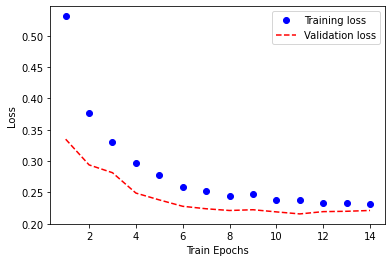

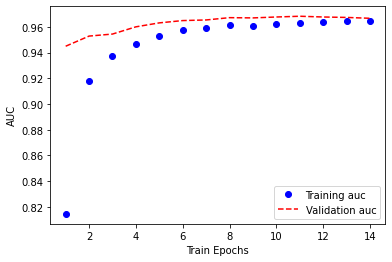

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

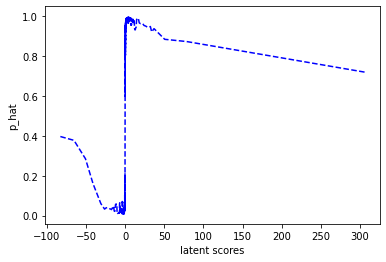

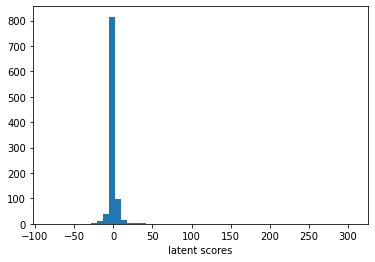

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

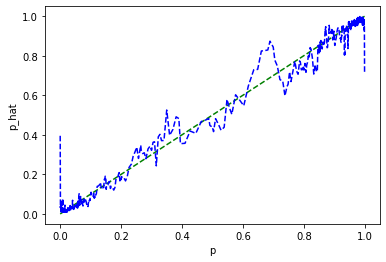

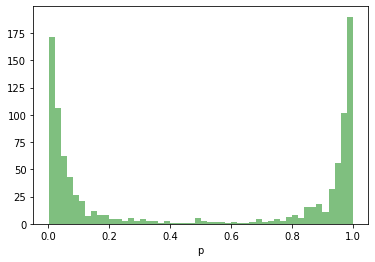

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

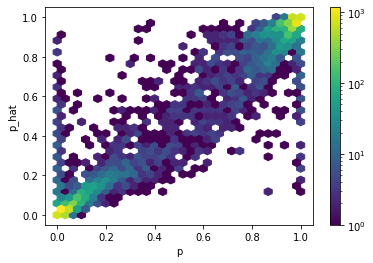

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

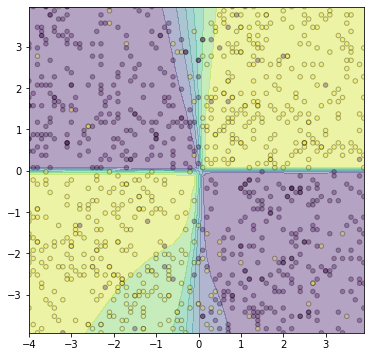

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = 0. * np.ones((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 60)                660       
                                                                 
 dropout_72 (Dropout)        (None, 60)                0         
                                                                 
 dense_97 (Dense)            (None, 60)                3660      
                                                                 
 dropout_73 (Dropout)        (None, 60)                0         
                                                                 
 dense_98 (Dense)            (None, 60)                3660      
                                                                 
 dropout_74 (Dropout)        (None, 60)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.005600000000000001,
 'batch': 8,
 'epoch': 10,
 'optimizer': 'adamax',
 'best_loss': {'loss': 0.21734558045864105, 'epoch': 14},
 'best_auc': {'auc': 0.9683008193969727, 'epoch': 16},
 'best_accuracy': {'accuracy': 0.9258999824523926, 'epoch': 14},
 'model': <keras.engine.sequential.Sequential at 0x7f8771af0ee0>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.2969895601272583, 'epoch': 394},
  'best_auc': {'auc': 0.9507202506065369, 'epoch': 393},
  'best_accuracy': {'accuracy': 0.9102500081062317, 'epoch': 393}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.27583417296409607, 'epoch': 394},
  'best_auc': {'auc': 0.9556026458740234, 'epoch': 394},
  'best_accuracy': {'accuracy': 0.918749988079071, 'epoch': 385}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.2591339945793152, 'epoch': 394},
  'best_auc': {'auc': 0.9588718414306641, 'epoch': 394},
  'best_accuracy': {'accuracy': 0.9188500046730042, 'epoch': 383}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 590,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.26942962408065796, 'epoch': 828},
  'best_auc': {'auc': 0.9580510258674622, 'epoch': 828},
 

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25